# Capacitated Facility Location Problem - Version #4 
This version attempts to integrate OD matrix into the objective function. Whereas the previous versions calculate transport cost as a function of distance and flow between farms and plants. 

The code kind of work atm. However, the constraints need to be improved. The problem is considered infeasible if not all of the farms can be assigned to a plant. 
https://www.youtube.com/watch?v=Ds5whiQXdbw&ab_channel=Hakeem-Ur-Rehman

In [756]:
from pulp import *
import pandas as pd
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [757]:
version_number = 4

In [758]:
# Define the manure utilization goal
manure_utilization_goal = 0.7

In [759]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [760]:
# Define the capacities of digester
medium_digester_capacity = 7848  # in tonne/yr
large_digester_capacity = 15056  # in tonne/yr

In [761]:
# Define the costs of digester 
medium_digester_cost = 209249   # in euro CAPEX
large_digester_cost = 252616    # in euro CAPEX

In [762]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [763]:
# Create mock digester capacity data
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, large_digester_capacity, large_digester_capacity]

# Create mock digester cost data
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, large_digester_cost, large_digester_cost]

In [764]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,7431,2898090.0
1,1,6.837249,52.425084,7246,2825940.0
2,2,6.859361,52.386225,9639,3759210.0
3,3,6.753483,52.434382,9821,3830190.0
4,4,6.484077,52.243620,2732,1065480.0


In [765]:
farm = pd.DataFrame(farm.sample(n=15, random_state=42))
farm

,Unnamed: 0,x,y,manure_t,biogas_potential_m3
131,271,6.779408,52.170940,5377,2097030.0
19,19,6.924298,52.208248,5003,1951170.0
81,157,6.867179,52.238185,2274,886860.0
96,191,6.660532,52.198912,5512,2149680.0
56,111,6.462510,52.279628,2558,997620.0
12,12,6.988119,52.375898,8334,3250260.0
98,194,6.588357,52.235362,5619,2191410.0
65,131,6.634887,52.351974,9669,3770910.0
66,132,6.644223,52.354599,227,88530.0
18,18,6.851862,52.253702,9496,3703440.0


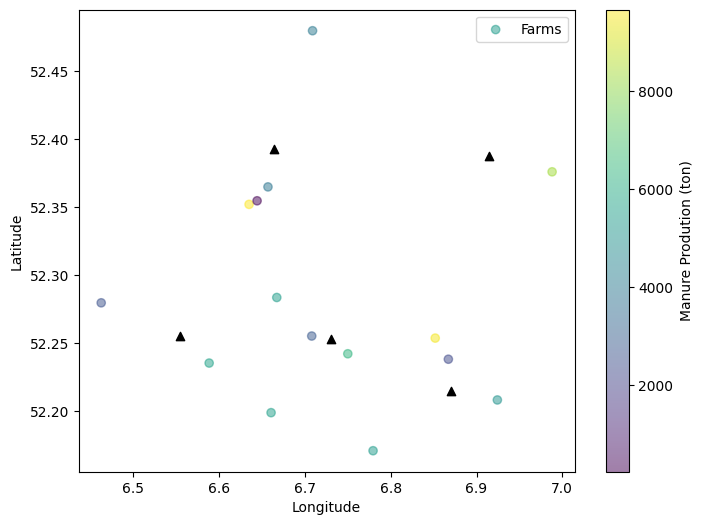

In [766]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(farm['x'], farm['y'], c=farm['manure_t'], alpha=0.5, label="Farms")
plt.scatter(potential_digester_location['x'], potential_digester_location['y'], marker='^', c='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Farm Clusters and Cluster Centroids')
cbar = plt.colorbar(scatter)

# Add labels to the colorbar
cbar.set_label('Manure Prodution (ton)')
plt.legend()
plt.show()

In [767]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # Customer = [1,2,3,4,5]
Plant = potential_digester_location.index.tolist()    # Facility = ['Fac-1', 'Fac-2', 'Fac-3']

In [768]:
# Dictionaries of the demands and facilities as well as fixed cost at each facility
Manure_Production = farm['manure_t'].to_dict()  # Demand = {1 : 80, 2 : 270, 3 : 250, 4 : 160, 5 : 180}
Max_Capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500} 
Fixed_Cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [769]:
type(Fixed_Cost.values())

dict_values

In [770]:
# string_values = {}
# non_string_values = {}

# for key, value in transportation_cost.items():
#     if isinstance(value, str):
#         string_values[key] = value
#     else:
#         non_string_values[key] = value

# print("String Values:")
# print(string_values)

# print("\nNon-String Values:")
# print(non_string_values)

In [771]:
# Create a mock distance matrix to store the euclidean distance between each potential digester location to every farm
transportation_cost = {} # NOTE THE TRANSPORTATION COST MATRIX IS A !DISTANCE MATRIX!

for plant_idx, plant_row in potential_digester_location.iterrows():
    plant_coords = (plant_row['y'], plant_row['x'])
    transportation_cost[plant_idx] = {}  # Create an inner dictionary for each plant

    for farm_idx, farm_row in farm.iterrows():
        farm_coords = (farm_row['y'], farm_row['x'])
        distance = euclidean(plant_coords, farm_coords)
        transportation_cost[plant_idx][farm_idx] = distance

# transportation_cost

In [772]:
# Define the total manure production by all farms
Total_Manure_Production = sum(Manure_Production[i] for i in Farm)

In [773]:
# Setting the Problem
prob = LpProblem("Capacitated_Facility_Location_Problem_V1", LpMinimize)

In [774]:
# Defining our Decision Variables
use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary) 
ser_farm = LpVariable.dicts("Farm_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary) 
# ser_farm = LpVariable.dicts("Farm_Plant", [(i,j) for i in Farm for j in Plant], 0)  

In [775]:
# Define binary decision variables for farm assignment
# farm_assignment = LpVariable.dicts("Farm_Assignment", Farm, 0, 1, LpBinary)

# # Create a binary variable to indicate if a farm supplies a plant
# farm_supplies_plant = LpVariable.dicts("Farm_Supplies_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary)

In [776]:
# Setting the Objective Function
# prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

    # prob += lpSum(fixed_cost[j]*use_facility[j] for j in Facility) + lpSum(transportation_cost[j][i]*ser_customer[(i,j)] for j in Facility for i in Customer)

In [777]:
# Costraints

for i in Farm:
    prob += lpSum(ser_farm[(i, j)] for j in Plant) <= 1 # Very strange, the model becomes infeasible  if it's == 1, maybe because now the constraint has relaxed and not all farms need to be assigned to facility, which will be the case if ==1

# The capacity constraint here it differnt than the one in paper, but i think it does the work still
for j in Plant:
    prob += lpSum(Manure_Production[i] * ser_farm[(i,j)] for i in Farm) <= Max_Capacity[j]*use_plant[j]

# Not really sure what this constraint does, I think it makes sure a farm can only be assigned to a facility given it's open, hence the value of xij is smaller or equal to yj 
for i in Farm:
    for j in Plant:
        prob += ser_farm[(i,j)] <= use_plant[j]

# Add a constraint to ensure at least x% of total manure production is sent to plants
prob += lpSum(Manure_Production[i] * ser_farm[(i, j)] for i in Farm for j in Plant) >= manure_utilization_goal * Total_Manure_Production

In [778]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze_env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/1017a1c7277147a99948ceb0efaa3ff6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/1017a1c7277147a99948ceb0efaa3ff6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 101 COLUMNS
At line 722 RHS
At line 819 BOUNDS
At line 900 ENDATA
Problem MODEL has 96 rows, 80 columns and 380 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 979712 - 0.00 seconds
Cgl0008I 15 inequality constraints converted to equality constraints
Cgl0003I 0 fixed, 0 tightened bounds, 35 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 34 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 ti

1

In [779]:
status = LpStatus[prob.status]


In [780]:
print("Solution Status = ", LpStatus[prob.status])

Solution Status =  Optimal


In [781]:
# if status == "Optimal":
#     # Retrieve and store the variable values
#     optimal_x = use_facility.varValue
#     optimal_y = ser_customer.varValue

#     # Retrieve and store the optimal objective value
#     optimal_obj_value = prob.objective.value()
# else:
#     optimal_x = None
#     optimal_y = None
#     optimal_obj_value = None

# print("Optimization Status:", status)
# print("Optimal x:", optimal_x)
# print("Optimal y:", optimal_y)
# print("Optimal Objective Value:", optimal_obj_value)

In [782]:
# # Print the status of the optimization
# print("Optimization Status:", LpStatus[prob.status])

# # Print the optimal values of decision variables
# for j in Facility:
#     print(f"Use Facility {j}: {use_facility[j].varValue}")

# for i in Customer:
#     for j in Facility:
#         print(f"Service customer {i} from Facility {j}: {ser_customer[(i, j)].varValue}")

In [783]:
# # Print the solution of Binary Decision Variables
# Tolerance = 0.0001
# for j in Plant:
#     if use_plant[j].varValue > Tolerance:
#         print("Estalish Facility at site = ", j)

In [784]:
# Print the solution of Continuous Decision Variables
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

In [785]:
# Initialize lists to store assignment information
assigned_farms = {j: [] for j in Plant}

# Collect assigned farms
for i in Plant:
    for j in Farm:
        if ser_farm[(j,i)].varValue > 0.00001:
            assigned_farms[i].append(j)

In [786]:
assigned_farms

{0: [131, 81], 1: [98], 2: [51, 77, 93], 3: [19, 12], 4: [65, 130]}

### Note that...
When an optimal solution is infeasible, the assignment matrix generated will not be binary. For example in the case of 15 farms and given the totoal capacity of the maximum 5 plants that can be opened, the maximum total manure utilization goal can only be 0.7. Because the total capacity of 5 plants, if they're all open, would be slightly less than 80% of the total manure production. 

In [787]:
# assignment_matrix = pd.DataFrame(index=facilities, columns=customers)

# for i in facilities:
#     for j in customers:
#         assignment_matrix.at[i, j] = x[(i, j)].varValue

assignment_matrix = pd.DataFrame(index=Farm, columns=Plant)

for i in Plant:
    for j in Farm:
        assignment_matrix.at[j, i] = ser_farm[(j, i)].varValue

assignment_matrix

,0,1,2,3,4
131,1.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,1.0,0.0
81,1.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0
98,0.0,1.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,1.0
66,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0


In [788]:
# Print the assignment of clients to plants
# for i in Farm:
#     for j in Plant:
#         if ser_farm[(i, j)].varValue == 1:
#             print(f"Assign {i} to {j}")
for i in Farm:
    for j in Plant:
        if ser_farm[(i, j)].varValue > 0 :
            print(f"Assign {i} to {j}")

Assign 131 to 0
Assign 19 to 3
Assign 81 to 0
Assign 12 to 3
Assign 98 to 1
Assign 65 to 4
Assign 51 to 2
Assign 77 to 2
Assign 93 to 2
Assign 130 to 4


In [789]:
# Check if the opened plants are under-utilized
potential_digester_location['allocated_manure'] = assignment_matrix.sum(axis = 0)
potential_digester_location

,x,y,capacity,cost,allocated_manure
0,6.870686,52.215190,7848,209249,2.0
1,6.554937,52.254895,7848,209249,1.0
2,6.730518,52.252885,15056,252616,3.0
3,6.914234,52.387401,15056,252616,2.0
4,6.664105,52.392622,15056,252616,2.0


In [791]:
# Find the percentage of plant's capacity that is utilized 

potential_digester_location['percentage_utilized'] = 0

for index, row in potential_digester_location.iterrows():
    if row['allocated_manure'] > 0:
        potential_digester_location.at[index, 'percentage_utilized'] = (row['allocated_manure'] / row['capacity']) * 100

In [792]:
def find_farm_not_in_solution_plant_in_solution(solution_dictionary, farm_df):
    """
    Input:
        solution_dictionary: dictionary of model output {plant:[all the assigned farms]}
        farm_df: DataFrame of farm data

    Return:
        empty_keys_unused_plant: a list of indices of unused plants
        farm_not_in_solution: a list of indices of excluded farms
    """
    
    # Find plants that in the optimal solution
    plant_in_use = []
    
    for key, value in solution_dictionary.items():
        if value is not None and not (
            (isinstance(value, str) and value.strip() == '') or
            (isinstance(value, (list, dict)) and not value)
        ):
            plant_in_use.append(key)
    
    # Find farms that are excluded in the optimal solution aka. it is not assigned to any plants
    # Append the lists from the dictionary to a combined list
    combined_dict = []

    for key in solution_dictionary:
        combined_dict.extend(solution_dictionary[key])
    
    farm_not_in_solution = []

    for index_value in farm_df.index:
        if index_value not in combined_dict:
            farm_not_in_solution.append(index_value)
    
    return plant_in_use, farm_not_in_solution 

In [793]:
plant_in_use, farm_not_in_solution = find_farm_not_in_solution_plant_in_solution(assigned_farms, farm)

In [794]:
# # Count the number of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(len(assigned))

In [795]:
# # Check the indices of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(assigned)

PROBLEM!! The number of farms that are not_in_any_solution combined with all the farms that are included add up to 143, which is 1 more than the actual count of farms....

Just checked and *18* has duplicates. So Farm 18 is assigned to Plant 1 and 4. 


In [796]:
# Check duplicates

# Initialize a dictionary to store seen values
seen = {}
# Initialize a list to store duplicate values
duplicates = []

# Iterate through the list
for item in farm_not_in_solution:
    # If the item is already in the dictionary, it's a duplicate
    if item in seen:
        duplicates.append(item)
    else:
        seen[item] = True

if duplicates:
    print("Duplicate values:", duplicates)
else:
    print("There are no duplicates in the list.")

There are no duplicates in the list.


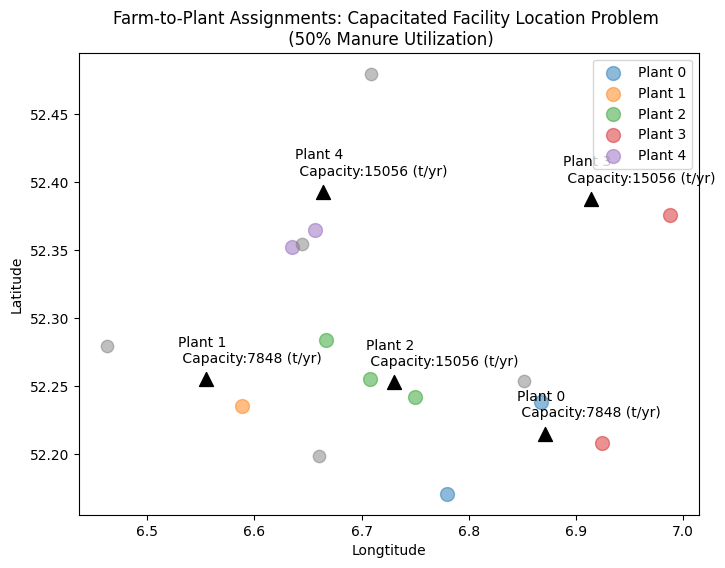

In [797]:
# Visualize the results
plt.figure(figsize=(8, 6))

# Plot plants in solution
# for i in plant_in_use:
#     plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=50, c='Black')
#     label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
#     plt.annotate(label, # this is the text
#                  (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(-20,10), # distance from text to points (x,y)
#                  ha='left', va='bottom') # horizontal alignment can be left, right or center
    
for i in Plant:
    plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=100, c='Black')
    label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
    plt.annotate(label, # this is the text
                 (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,10), # distance from text to points (x,y)
                 ha='left', va='bottom') # horizontal alignment can be left, right or center 

# Plot farms in solution
for j in Plant:
    assigned = assigned_farms[j]
    plt.scatter([farm.loc[i, 'x'] for i in assigned], [farm.loc[i, 'y'] for i in assigned], label=f"Plant {j}", marker='o', s=100, alpha=0.5)

# Plot farms excluded in solution
for i in farm_not_in_solution:
    plt.scatter(farm.loc[i, 'x'], farm.loc[i, 'y'], marker='o', s=80, c='Grey', alpha=0.5)

# for i, (x_val, y_val) in enumerate(zip(x, y)):
#     label = f'Point {i+1} ({x_val}, {y_val})'  # Create a label for each data point
#     plt.annotate(label, (x_val, y_val), textcoords="offset points", xytext=(0, 10), ha='center')


# scatter = plt.scatter(potential_digester_location['x'], potential_digester_location['y'], c=potential_digester_location['capacity'], label="Plant Locations", marker='s', s=50)
# Add labels based on 'Label' column
# for i, row in potential_digester_location.iterrows():
#     plt.annotate(row['capacity'], (row['x'], row['y']), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and legend
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.title("Farm-to-Plant Assignments: Capacitated Facility Location Problem \n (50% Manure Utilization)")
plt.legend()
# legend = plt.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1.0, 1.0))

# # Create a dictionary to map unique values to custom legend labels
# custom_labels = {'A': 'Category 1', 'B': 'Category 2', 'C': 'Category 3'}

# # Replace unique values with custom labels for the legend
# legend_labels = [custom_labels[label] for label in df['Label'].unique()]

# # Create the legend with custom labels
# legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

# filename = f"cflp_v{version_number}_{int(manure_utilization_goal*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

# plt.savefig(filename, dpi=300)

plt.show()

In [798]:
# Print Optimal
print("Total Cost = ", value(prob.objective))

Total Cost =  1176346.6116906174
